# Problem 1 (Practice)

In HW 2 we studied the motion of a system of $N$ identical masses joined by identical linear springs like this:

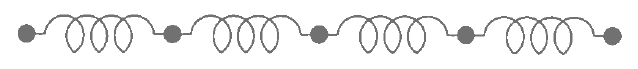

As we showed, the horizontal displacements $\xi_i$ of masses $i=1...N$ satisfy equations of motion
\begin{align*}
  m\frac{d^2\xi_1}{dt^2} &= k(\xi_2-\xi_1) + F_1, \\
  m\frac{d^2\xi_i}{dt^2} &= k(\xi_{i+1}-\xi_i) + k(\xi_{i-1}-\xi_i) + F_i, \\
  m\frac{d^2\xi_N}{dt^2} &= k(\xi_{N-1}-\xi_N) + F_N,
\end{align*}
where $m$ is the mass, $k$ is the spring constant, and $F_i$ is the external force on mass $i$. In HW2, we showed how these equations could be solved by guessing a form for the solution and using a matrix method. Here we'll solve them more directly.

(a) Write a program to solve for the motion of the masses using the Leapfrog  method for the case we studied previously where $m=1$ and $k=6$, and the driving forces are zero except for $F_1 = \cos \omega t$ with $\omega=2$ (Do not worry about advancing position by a half timestep). Plot your solutions for the displacements $\xi_i$ of all the masses as a function of time from $t=0$ to $t=100$ on the same plot. (60 pts)

(b) Write a code to create an animation of the movement of the masses. [Hint: use the FuncAnimation function from the matplotlib.animation library.] (30 pts)

(c) Plot $\xi_i$ vs. i at the final time. Compare it to the solution you obtained in HW2. (10 pts)

---
# Problem 2

We wish to solve the Lorentz force equation, given by
\begin{align*}
  m\frac{d\mathbf{v}}{dt} = q(\mathbf{E} + \mathbf{v}\times\mathbf{B}).
\end{align*}
The Leapfrog scheme can be expressed as
\begin{align*}
  \frac{\mathbf{v}_{t+1}-\mathbf{v}_t}{\Delta} = f\left(\frac{\mathbf{v}_{t+1}+\mathbf{v}_t}{2},t\right)
\end{align*}


(a) Define, the angular cyclotron frequency vector $\mathbf{\Omega} =q\mathbf{B}/m$ and the normalized electric field $\Sigma = q\mathbf{E}/m$ so that the above equation becomes
\begin{align}
  \frac{d\mathbf{v}}{dt} = \mathbf{\Sigma} + \mathbf{v}\times\mathbf{\Omega}.
\end{align}
Invoke the Leapfrog algorithm to show that the above equation becomes
\begin{align*}
  \mathbf{v}_{t+1}+\mathbf{A}\times\mathbf{v}_{t+1} = \mathbf{C}
\end{align*}
where $\mathbf{A} = \mathbf{\Omega}\Delta t/2
  ,$ and $\mathbf{C} = \mathbf{v}_t + \Delta t (\mathbf{\Sigma} + \mathbf{v}_t \times \mathbf{\Omega}/2)$. (15 pts)


(b) By first dotting the above equation with $\mathbf{A}$ and then crossing it with $\mathbf{A}$, show that the new value of velocity is given by
\begin{align*}
  \mathbf{v}_{t+1} = \frac{\mathbf{C} + \mathbf{A}(\mathbf{A}\cdot\mathbf{C}) - \mathbf{A}\times\mathbf{C}}{1+A^2}
\end{align*}
The position is then simply
\begin{align*}
  \mathbf{x}_{t+3/2} = \mathbf{x}_{t+1/2}+\mathbf{v}_{t+1}\Delta t
\end{align*}

(15 pts)

(c) Write a code that implements this algorithm for arbitrary $\mathbf{\Sigma}$ and $\mathbf{\Omega}$ [Hint: use the np.dot and np.cross functions]. Integrate the trajectory of a particle for $\mathbf{\Sigma}=(0,0,0)$ and $\mathbf{\Omega}=(0,0,1)$ from $t=0$ to $t=50$ and plot it on the $x-y$ plane for $\mathbf{x}(t=0)=(0,0,0)$ and $\mathbf{v}(t=0)=(0.1,0,0)$. Is the trajectory what you expect? Plot the energy of the particle as a function of time. Is it more or less conserved? (40 pts)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def boris_velocity_update(v_t, A, C):
    denom = 1.0 + np.dot(A, A)
    return (C + A * np.dot(A, C) - np.cross(A, C)) / denom

def leapfrog_step(x_half, v_t, t, dt, Omega, Sigma_fn):
    A = 0.5 * dt * Omega
    C = v_t + dt * (Sigma_fn(x_half, t) + 0.5 * np.cross(v_t, Omega))
    v_next = boris_velocity_update(v_t, A, C)
    x_half_next = x_half + v_next * dt
    return v_next, x_half_next

def integrate(T, dt, x0, v0, Omega, Sigma_fn):
    N = int(np.floor(T / dt))
    t = 0.0
    v = np.array(v0, dtype=float)
    x_half = np.array(x0, dtype=float) + 0.5 * dt * v
    xs = np.zeros((N + 1, 3))
    vs = np.zeros((N + 1, 3))
    ts = np.zeros(N + 1)
    Ek = np.zeros(N + 1)
    xs[0] = x_half
    vs[0] = v
    ts[0] = t
    Ek[0] = 0.5 * np.dot(v, v)
    for n in range(N):
        v, x_half = leapfrog_step(x_half, v, t, dt, Omega, Sigma_fn)
        t += dt
        xs[n + 1] = x_half
        vs[n + 1] = v
        ts[n + 1] = t
        Ek[n + 1] = 0.5 * np.dot(v, v)
    return ts, xs, vs, Ek

def Sigma_zero(x, t):
    return np.array([0.0, 0.0, 0.0])

def Sigma_const(Ex=0.0, Ey=0.0, Ez=0.0):
    const_vec = np.array([Ex, Ey, Ez], dtype=float)
    def _Sigma(x, t):
        return const_vec
    return _Sigma

def Sigma_wave_y(E0, k, omega):
    def _Sigma(x, t):
        return np.array([0.0, E0 * np.sin(k * x[1] - omega * t), 0.0])
    return _Sigma

def time_average(vs, fraction_exclude=0.5):
    n0 = int(fraction_exclude * len(vs))
    return vs[n0:].mean(axis=0)

def plot_xy(xs, title):
    plt.figure()
    plt.plot(xs[:, 0], xs[:, 1], lw=1.2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.title(title)

def plot_energy(ts, Ek, title):
    plt.figure()
    plt.plot(ts, Ek, lw=1.2)
    plt.xlabel("t")
    plt.ylabel("Kinetic energy (m=1)")
    plt.title(title)

def run_part_c():
    dt = 0.01
    T = 50.0
    Omega = np.array([0.0, 0.0, 1.0])
    x0 = np.array([0.0, 0.0, 0.0])
    v0 = np.array([0.1, 0.0, 0.0])
    ts, xs, vs, Ek = integrate(T, dt, x0, v0, Omega, Sigma_zero)
    plot_xy(xs, "(c) x–y trajectory: Σ=0, Ω=(0,0,1)")
    plot_energy(ts, Ek, "(c) Kinetic energy vs time (Σ=0)")
    return ts, xs, vs, Ek

def run_part_d():
    dt = 0.01
    T = 200.0
    Ex = 0.1
    Omega = np.array([0.0, 0.0, 1.0])
    x0 = np.array([0.0, 0.0, 0.0])
    v0 = np.array([0.0, 0.0, 0.0])
    Sigma_fn = Sigma_const(Ex=Ex, Ey=0.0, Ez=0.0)
    ts, xs, vs, Ek = integrate(T, dt, x0, v0, Omega, Sigma_fn)
    plot_xy(xs, f"(d) E×B drift (Σ=(0.1,0,0), Ω=(0,0,1))")
    vE_theory = np.cross(np.array([Ex, 0.0, 0.0]), Omega) / np.dot(Omega, Omega)
    v_avg = time_average(vs, fraction_exclude=0.5)
    print("(d) Long-time averaged velocity (numerical):", v_avg, "|v_avg| =", np.linalg.norm(v_avg))
    print("(d) E×B drift (theory):", vE_theory, "|v_E| =", np.linalg.norm(vE_theory), "= E/B")
    return ts, xs, vs, Ek

def run_part_e():
    dt = 0.01
    T = 300.0
    k = 1.0
    omega = 0.2
    Omega = np.array([0.0, 0.0, 1.0])
    x0 = np.array([0.0, 0.0, 0.0])
    v0 = np.array([0.0, 0.0, 0.0])
    E0_1 = 0.1
    Sigma1 = Sigma_wave_y(E0_1, k, omega)
    ts1, xs1, vs1, Ek1 = integrate(T, dt, x0, v0, Omega, Sigma1)
    plot_xy(xs1, f"(e) Wave E-field trajectory (E0={E0_1}, k={k}, ω={omega})")
    print("(e) Criterion k*E0/|Ω|^2 (E0=0.1):", k * E0_1 / np.dot(Omega, Omega))
    E0_2 = 1.1
    Sigma2 = Sigma_wave_y(E0_2, k, omega)
    ts2, xs2, vs2, Ek2 = integrate(T, dt, x0, v0, Omega, Sigma2)
    plot_xy(xs2, f"(e) Wave E-field trajectory (E0={E0_2}, k={k}, ω={omega})")
    print("(e) Criterion k*E0/|Ω|^2 (E0=1.1):", k * E0_2 / np.dot(Omega, Omega), "> 1 ⇒ chaotic motion likely")
    return (ts1, xs1, vs1, Ek1), (ts2, xs2, vs2, Ek2)


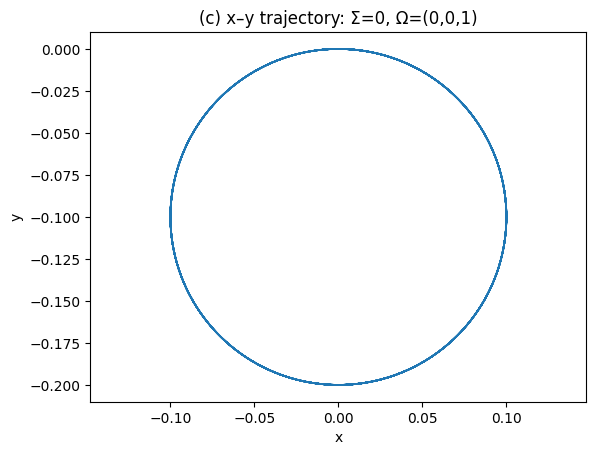

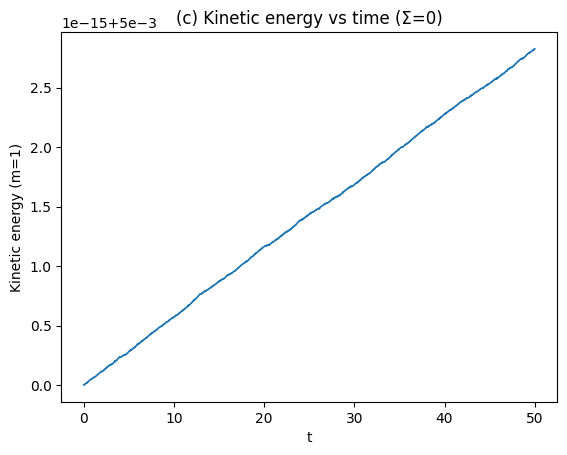

In [3]:
run_part_c()
plt.show()

(d) Change the electric field to $\mathbf{\Sigma}=(0.1,0,0)$ and initial velocity to $\mathbf{v}(t=0)=(0,0,0)$. What happens and what is the average velocity of the particle? Confirm that this average velocity has the magnitude $E/B$. This average particle motion is called "$\mathbf{E}\times\mathbf{B}$ drift" and is equal to $\mathbf{v}_E = \frac{\mathbf{E}\times\mathbf{B}}{B^2}$. (15 pts)

(d) Long-time averaged velocity (numerical): [ 0.00036922 -0.10036025  0.        ] |v_avg| = 0.10036092900822668
(d) E×B drift (theory): [ 0.  -0.1  0. ] |v_E| = 0.1 = E/B


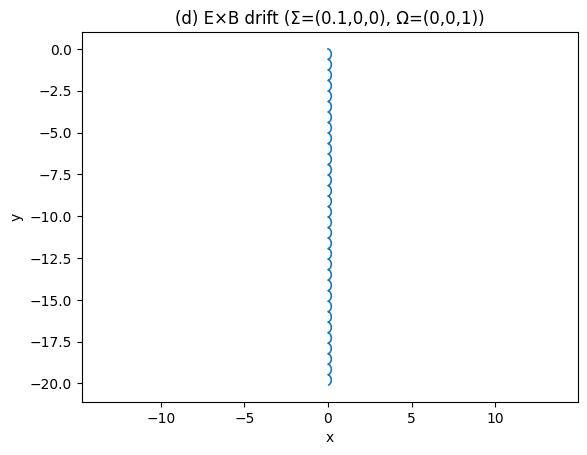

In [4]:
run_part_d()
plt.show()

(e) Now change the electric field to $\mathbf{E} = (0,E_0\sin(ky-\omega t),0)$ for $E_0=0.1$, $k=1$ and $\omega=0.2$ and plot the particle trajectory in the $x-y$ plane. Now change $E_0=1.1$. Qualitative describe the difference between the two trajectories. For your information, in the latter case, the particle is actually undergoing chaotic motion (sensitive to initial conditions), and the criterion for this motion is
\begin{align*}
  \frac{mkE_0}{qB^2}>1
\end{align*}
(15 pts)

(e) Criterion k*E0/|Ω|^2 (E0=0.1): 0.1
(e) Criterion k*E0/|Ω|^2 (E0=1.1): 1.1 > 1 ⇒ chaotic motion likely


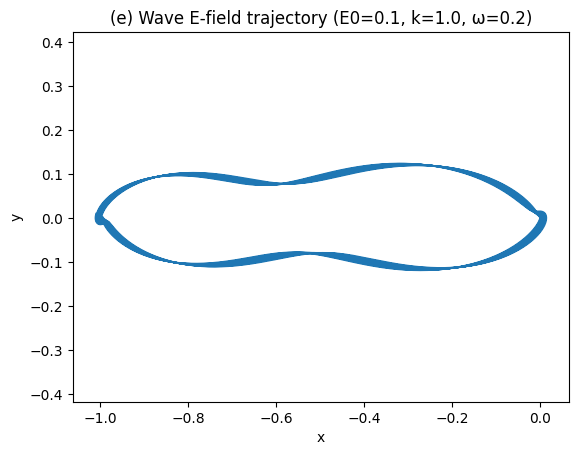

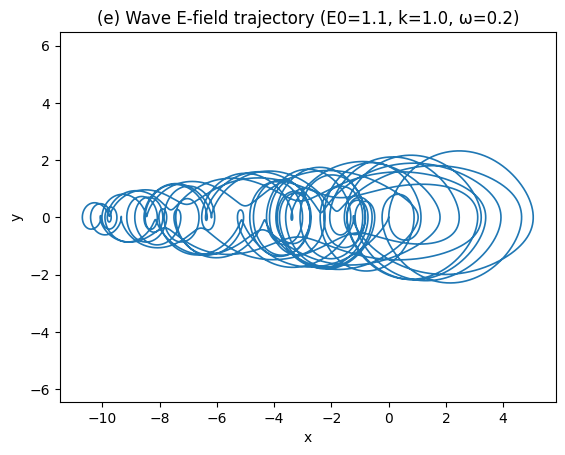

In [5]:
run_part_e()
plt.show()